In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import librosa
from librosa.core.spectrum import _spectrogram
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# load data
df_resampled_pre = pd.read_pickle("./data_for_modeling_jare60.pickle")
#df_resampled = pd.read_pickle("./data_for_modeling_jare59.pickle")

In [3]:
df_resampled_hour = df_resampled_pre.asfreq("S")
SPC_mean = df_resampled_hour['SPC_flux[mm]'].resample("min").sum()
df_resampled_minute = df_resampled_hour.resample("min").mean()
df_resampled_minute["SPC_flux[mm]"] = SPC_mean
df_resampled_minute = df_resampled_minute.dropna()

4362 994 22.787712058688676
['pitch', 'Relative wind speed[m/s]', 'relative_wind_cos', 'relative_wind_sin', 'Speed[knot]', 'mwp', 't2m', 'sst', 'swh', 'u10', 'v10', 'relative_wind_y', 'tp', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 'Relative_wind_direction[deg]', 'Relative wave direction[deg]', 'Speed[m/s]', 'encounter cycle', 'wave_length', 'ratio']


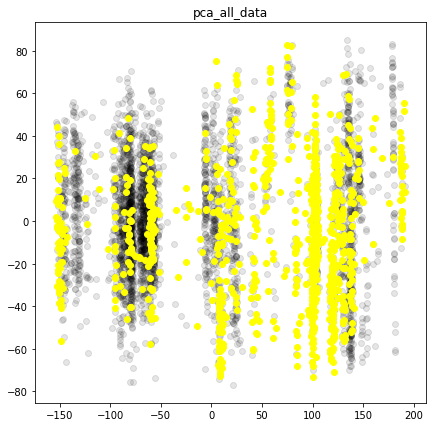

<Figure size 432x288 with 0 Axes>

In [12]:
#df_resampled = pd.read_pickle("./data_for_modeling_jare60.pickle")

df_resampled = df_resampled_minute
del df_resampled_minute
columns = ['ピッチ (度)', 'Relative wind speed[m/s]', '相対風速 (m/s)_cos', '相対風速 (m/s)_sin', 'Speed[knot]', 'SPC_flux[mm]', 'mwp', 't2m', 'sst', 'swh', 'u10', 'v10', 'relative_wind_y', 'label', 'tp']
columns.extend([i+1 for i in range(30)])
columns.extend(['Relative_wind_direction[deg]', 'Relative wave direction[deg]', 'Speed[m/s]', 'encounter cycle', 'wave_length', 'ratio'])
df_resampled = df_resampled.loc[:, columns]

# SPC_mean = df_resampled['SPC_flux[mm]'].resample("min").sum()
# df_resampled_minute = df_resampled.resample("min").nearest()
# df_resampled_minute['SPC_flux[mm]'] = SPC_mean
#df_resampled_hour = df_resampled.resample("H").nearest()
#df_resampled_hour['tp'] = df_resampled_hour['tp'] * 3600
df_resampled_minute = df_resampled
df_resampled_minute['tp'] = df_resampled_minute['tp'] * 60
df_resampled_minute = df_resampled_minute[df_resampled_minute['tp'] < (0.01 / 1000) / 60]
#df_resampled_hour = df_resampled_hour[df_resampled_hour['tp'] < (0.01 / 1000)]
#df_resampled = df_resampled[df_resampled['tp'] < (0.01 / 1000) / 3600]
df_copy = df_resampled_minute

#plt.plot(np.arange(len(SPC_mean)), SPC_mean)
#df_copy = df_resampled.copy()
# 飛沫データのラベリング
spray_all = np.array(df_copy['SPC_flux[mm]'])

# 飛沫発生ならlabel=1, 飛沫0.0ならlabel=0
spc_label = [1 if i > 1 else 0 for i in spray_all]
df_copy['label'] = spc_label
print(len(df_copy), len(df_copy[df_copy['label'] != 0.0]), len(df_copy[df_copy['label'] != 0.0]) / len(df_copy) * 100)
df_copy = df_copy.rename(columns={'ピッチ (度)':'pitch', '相対風速 (m/s)_sin':'relative_wind_sin', '相対風速 (m/s)_cos':'relative_wind_cos'})

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

#for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
for_modeling = all_columns
#for_modeling.remove('tp')
#for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
#label = np.array(df_copy['label'])

#X = df_copy.loc[:, [i for i in df_copy.columns if i != 'SPC_flux[mm]' and i != 'label']]
#print(X.columns)
y = df_copy.loc[:, "label"]

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=100,
                                     file_path='/home/nt/Desktop/soturon'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        tsne = TSNE(n_components=2, random_state=random_state)
        transformed = tsne.fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    #print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title(image_name)
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))


plot_reduced_graph(X, y, 'pca_all_data', model="pca", random_sampling=False, random_state=200)

# 普通にlightgbm

In [101]:
df_resampled_ = pd.read_pickle("./data_for_modeling_jare60.pickle")
#print(df_resampled_["SPC_flux[mm]"].describe())
for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]', "SPC_flux[mm]", "tp"]
for_modeling.extend([i+1 for i in range(10)])
print(df_resampled.shape)
th_spc = 0.01
df_copy_ = fix_df(df_resampled_, th_spc, for_modeling)
print(df_copy_.shape, len(df_copy_[df_copy_["label"] != 0]))

count    196151.000000
mean         86.083568
std         483.286971
min           0.017332
25%           1.894407
50%           7.447792
75%          29.211121
max        8520.904998
Name: SPC_flux[mm], dtype: float64
(2653901, 69)
1  (196151, 17)
2  (150529, 17)
3  (3275, 17)
(478, 18) 391


In [227]:
def fix_df(df_resampled_pre, th_spc, feature):
#     th_spc = th_spc * 60
#     columns = ['ピッチ (度)', 'Relative wind speed[m/s]', '相対風速 (m/s)_cos', '相対風速 (m/s)_sin', 'Speed[knot]', 'SPC_flux[mm]', 'mwp', 't2m', 'sst', 'swh', 'u10', 'v10', 'relative_wind_y', 'label', 'tp']
#     columns.extend([i+1 for i in range(30)])
#     columns.extend(['Relative_wind_direction[deg]', 'Relative wave direction[deg]', 'Speed[m/s]', 'encounter cycle', 'wave_length', 'ratio'])
    df_resampled_pre = df_resampled_pre.loc[:, feature]
#     print("1 ", df_resampled_pre.shape)
    
    df_resampled_hour = df_resampled_pre.asfreq("S")
#     print(df_resampled_hour)
    SPC_mean = df_resampled_hour['SPC_flux[mm]'].resample("min").mean()
    df_resampled_minute = df_resampled_hour.resample("min").nearest()
    df_resampled_minute["SPC_flux[mm]"] = SPC_mean
    print(df_resampled_minute.shape)
#     print("2 ", df_resampled_minute.shape)
#     print(df_resampled_minute)
    df_resampled_minute = df_resampled_minute.dropna()
    df_resampled_minute = df_resampled_minute[df_resampled_minute["SPC_flux[mm]"] >= 0]
    #plot_graph(df_resampled_minute, "SPC_flux[mm]", "Time[minute]", "Flux[mm]", "jare60_spc_after_reduced.png")
    print(df_resampled_minute.shape)
    df_resampled = df_resampled_minute
#     print("3 ", df_resampled.shape)
    del df_resampled_minute
    
    #plot_graph(df_resampled, "SPC_flux[mm]", "Time[minute]", "Flux[mm]", "jare60_spc.png")

    df_resampled['tp'] = df_resampled['tp'] * 60
    df_resampled = df_resampled[df_resampled['tp'] < (0.01 / 1000) / 60]
    #plot_graph(df_resampled, "SPC_flux[mm]", "Time[minute]", "Flux[mm]", "jare60_spc_after_reduced_by_tp.png")
    print(df_resampled.shape)
    df_copy = df_resampled.copy()
    # 飛沫データのラベリング
    spray_all = np.array(df_copy['SPC_flux[mm]'])
    #print(df_copy['SPC_flux[mm]'].describe())
    # 飛沫発生ならlabel=1, 飛沫0.0ならlabel=0
    spc_label = [1 if i > th_spc else 0 for i in spray_all]
    df_copy['label'] = spc_label
    #print(len(df_copy), len(df_copy[df_copy['label'] != 0.0]), len(df_copy[df_copy['label'] != 0.0]) / len(df_copy) * 100)
    df_copy = df_copy.rename(columns={'ピッチ (度)':'pitch', '相対風速 (m/s)_sin':'relative_wind_sin', '相対風速 (m/s)_cos':'relative_wind_cos'})
    return df_copy

In [151]:
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 15 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 10 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 24 # 軸だけ変更されます

plt.rcParams['xtick.direction'] = 'in' # x axis in
plt.rcParams['ytick.direction'] = 'in' # y axis in 
plt.rcParams['axes.linewidth'] = 1.0 # axis line width
plt.rcParams['axes.grid'] = True # make grid

def plot_graph(data, feature, x_label_name, y_label_name, filename):
    plt.figure(figsize=(15, 4))
    plt.plot(np.arange(len(data)), data.loc[:, feature], color="black")
    plt.xlabel(str(x_label_name))
    plt.ylabel(str(y_label_name))
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

(150529, 36)
(3275, 36)
(478, 36)
count     478.000000
mean      233.365336
std       925.105600
min         0.017332
25%         1.197726
50%        13.127726
75%        52.170224
max      8520.904998
Name: SPC_flux[mm], dtype: float64
478 368


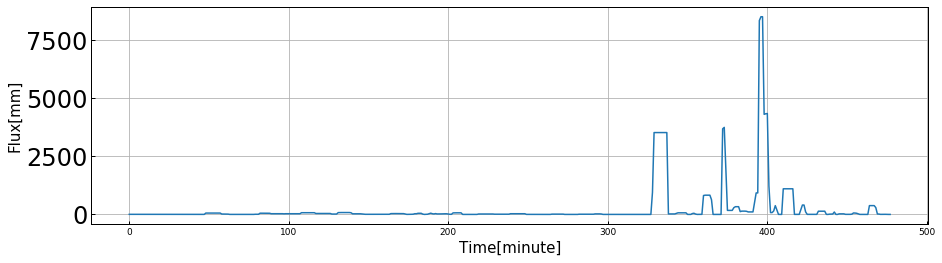

In [103]:
import copy
th_spc = 1
df_resampled = pd.read_pickle("./data_for_modeling_jare59.pickle")
for_modeling = ['ratio', 'swh', 'relative_wind_y', 'Speed[knot]']
for_modeling.extend([i+1 for i in range(30)])
tmp = copy.deepcopy(for_modeling)
tmp.extend(["SPC_flux[mm]", "tp"])
df_copy = fix_df(df_resampled, th_spc, tmp)
print(df_copy["SPC_flux[mm]"].describe())
print(len(df_copy), len(df_copy[df_copy["SPC_flux[mm]"] >= th_spc]))

Index([                     'ピッチ (度)',                  '中央Ax (m/s2)',
                        '中央Ay (m/s2)',                  '中央Az (m/s2)',
                          '南北速度 (kt)',               '右散水流量 (m3/min)',
                              '回転数調整',               '左散水流量 (m3/min)',
                          '東西速度 (kt)',     'Relative wind speed[m/s]',
                     '相対風速 (m/s)_cos',               '相対風速 (m/s)_sin',
                          '舵角　右舵 (度)',                    '舵角　左舵 (度)',
                        '船尾Ax (m/s2)',                  '船尾Ay (m/s2)',
                        '船尾Az (m/s2)',                  '船首Ax (m/s2)',
                        '船首Ay (m/s2)',                  '船首Az (m/s2)',
                        'Course[deg]',                  'Speed[knot]',
                       'SPC_flux[mm]',                          'mwp',
                                't2m',                          'sst',
                                'mwd',                           'tp',
      

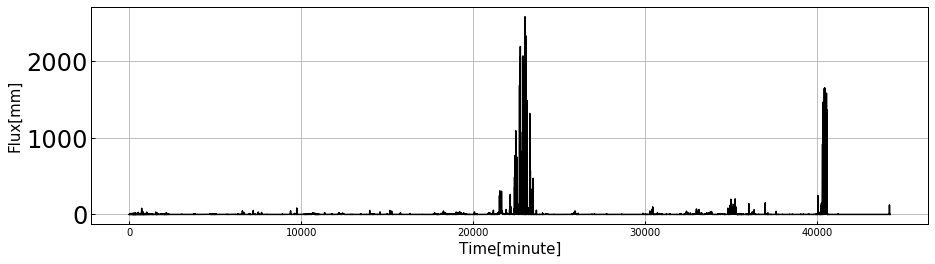

(44230, 36)


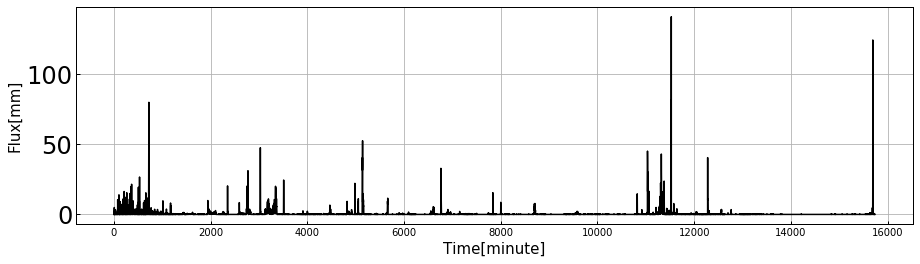

(15736, 36)
count    15736.000000
mean         0.411554
std          2.794208
min          0.000000
25%          0.000000
50%          0.000000
75%          0.006539
max        140.511395
Name: SPC_flux[mm], dtype: float64
15736 960


In [155]:
import copy
th_spc = 1
df_resampled = pd.read_pickle("./data_for_modeling_jare60.pickle")
print(df_resampled.columns)
for_modeling = ['ratio', 'swh', 'relative_wind_y', 'Speed[knot]']
for_modeling.extend([i+1 for i in range(30)])
tmp = copy.deepcopy(for_modeling)
tmp.extend(["SPC_flux[mm]", "tp"])
df_copy = fix_df(df_resampled, th_spc, tmp)
print(df_copy["SPC_flux[mm]"].describe())
print(len(df_copy), len(df_copy[df_copy["SPC_flux[mm]"] >= th_spc]))

In [116]:
df_resampled = pd.read_pickle("./data_for_modeling_jare60.pickle")

In [217]:
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 20 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 20 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 20 # 軸だけ変更されます

plt.rcParams['xtick.direction'] = 'in' # x axis in
plt.rcParams['ytick.direction'] = 'in' # y axis in 
plt.rcParams['axes.linewidth'] = 1.0 # axis line width
plt.rcParams['axes.grid'] = True # make gridams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 15 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 20 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 18 # 軸だけ変更されます

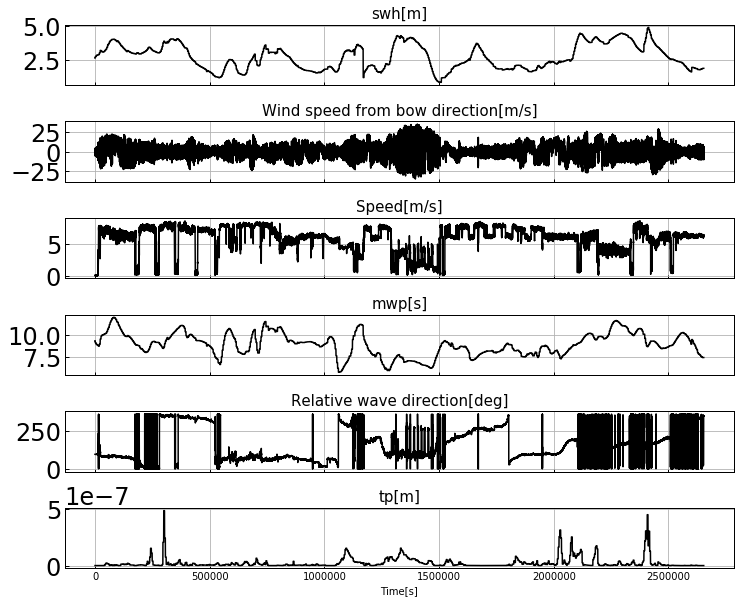

In [193]:
df_resampled = pd.read_pickle("./data_for_modeling_jare60.pickle")
features = ["swh", "relative_wind_y", "Speed[m/s]", "mwp", "Relative wave direction[deg]", "tp"]
names = ["swh[m]", "Wind speed from bow direction[m/s]", "Speed[m/s]", "mwp[s]", "Relative wave direction[deg]", "tp[m]"]
fig = plt.figure(figsize=(12, 10), facecolor='w', edgecolor='k')
for i, col in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.subplots_adjust(hspace=0.6)
    hours = 10
    sample = df_resampled.iloc[:,:]
    plt.plot(np.arange(len(sample)), sample[col], c="black")
    plt.title(names[i], fontsize=15)
    if i != (len(features)-1):
        plt.tick_params(labelbottom=False)
    else:
        plt.xlabel("Time[s]", fontsize=10)
    #plt.ylim([0, 30])
    #plt.colorbar()
plt.savefig("./raw_data.png")
plt.show()

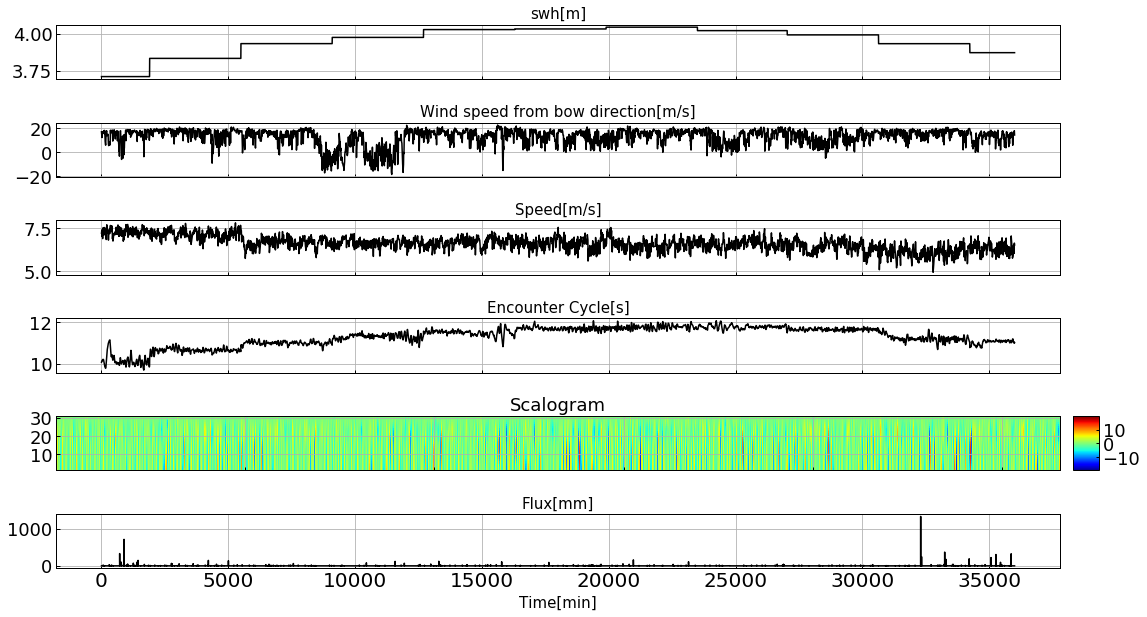

In [225]:
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable

df_resampled = pd.read_pickle("./data_for_modeling_jare60.pickle")
features = ["swh", "relative_wind_y", "Speed[m/s]", "encounter cycle", "freq", "SPC_flux[mm]"]
frequences = [i+1 for i in range(30)]
df_freq = df_resampled.loc[:, frequences]
names = ["swh[m]", "Wind speed from bow direction[m/s]", "Speed[m/s]", "Encounter Cycle[s]", "Frequency[Hz]", "Flux[mm]"]

fig = plt.figure(figsize=(18, 10), facecolor='w', edgecolor='k')
for i, col in enumerate(features):
    ax = plt.subplot(len(features), 1, i+1)
    plt.subplots_adjust(hspace=0.8)
    minute = 1000
    delta = 600
    if col != "freq":
        sample = df_resampled.iloc[minute * 60:(minute + delta) * 60,:]
        plt.plot(np.arange(len(sample)), sample[col], c="black")
        plt.title(names[i], fontsize=15)
        if col == "SPC_flux[mm]":
            plt.xlabel("Time[min]")
        else:
            plt.tick_params(labelbottom=False)
    else:
        plt.imshow(np.array(df_freq.iloc[minute * 60:(minute + delta) * 60,:].T),
                   extent=[0, len(df_freq), 1, 31], cmap='jet', aspect='auto',
                   vmax=abs(np.array(df_freq).max()), vmin=-abs(np.array(df_freq).max()))
        axpos = ax.get_position()
        cwtmatr = np.array(df_freq.iloc[minute * 60:(minute + delta) * 60,:]).T
        norm = colors.Normalize(vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
        mappable = ScalarMappable(cmap='jet', norm=norm)
        cbar_ax = fig.add_axes([0.91, axpos.y0, 0.02, axpos.height])
        ax.set_title("Scalogram")
        fig.colorbar(mappable, cax=cbar_ax)
        ax.tick_params(labelbottom=False)
        
plt.savefig("./saishu.png")
plt.show()

In [ ]:

ax[0].plot(x_range, np.array(jare60_pitch_after), color="black")
ax[0].set_title("Pitch")
ax[1].imshow(cwtmatr[:len(cwtmatr)], extent=[0, len(jare60_pitch_after), 1, 31], cmap='jet', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
ax[0].set_ylabel("Pitch Amplitude[deg]")
ax[1].set_xlabel("Time[s]")
ax[1].set_ylabel("Frequency[Hz]")
axpos = ax[1].get_position()
norm = colors.Normalize(vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
mappable = ScalarMappable(cmap='jet', norm=norm)
cbar_ax = fig.add_axes([0.91, axpos.y0, 0.02, axpos.height])
ax[1].set_title("Scalogram")
fig.colorbar(mappable, cax=cbar_ax)
plt.savefig("wavelet_1.eps", bbox_inches="tight", pad_inches=0.05)
plt.show()

In [152]:
def plot_graph(data, feature, x_label_name, y_label_name, filename):
    plt.figure(figsize=(15, 4))
    plt.plot(np.arange(len(data)), data.loc[:, feature], color="black")
    plt.xlabel(str(x_label_name))
    plt.ylabel(str(y_label_name))
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

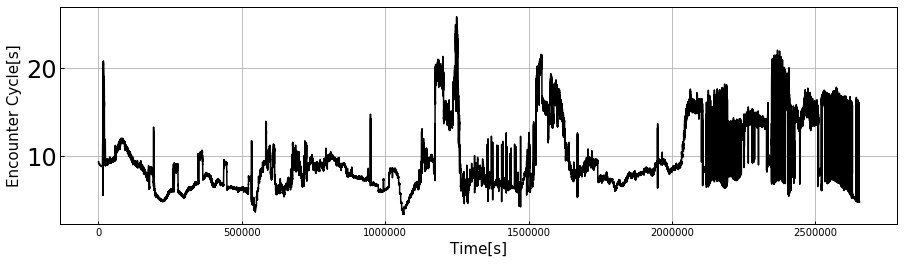

In [154]:
plot_graph(df_resampled, "encounter cycle", "Time[s]", "Encounter Cycle[s]", "deai_shuki.png")

# 実験版

In [78]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import lightgbm as lgb
import copy
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
import pickle 

th_spc_all = []
f_score_all = []
cms_all = []
recall_all = []
precision_all = []
accuracy_all = []
th_list_all = []

df_resampled = pd.read_pickle("./data_for_modeling_jare60.pickle")
df_resampled_ = pd.read_pickle("./data_for_modeling_jare59.pickle")
#th_spcs = [0.01 + 0.01 * k for k in range(0, 100, 1)]
#th_spcs = [0.2, 0.25]
th_spcs = [0.01]

for_modeling = ['encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['swh', 'mwp']
#for_modeling = ['swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['ratio', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling.extend([i+1 for i in range(30)])
#for_modeling = all_columns
print(for_modeling)
tmp = copy.deepcopy(for_modeling)
tmp.extend(["SPC_flux[mm]", "tp"])
for th_spc in th_spcs:
    df_copy = fix_df(df_resampled, th_spc, tmp)
#     print(for_modeling)
    print(df_resampled.shape, df_copy.shape)
    X = df_copy.loc[:, for_modeling]
    X = np.array(X)
    y = np.array(df_copy['label'])
    
    print(X.shape)

    # # SMOTE to balance dataset
#     sm = SMOTE()
#     X, y = sm.fit_sample(X, y)

    date = datetime.now()
    seed1 = date.minute + date.second + date.hour
#     seed1 = 1
#     print(seed1)

    def imbalanced_data_split(X, y, seed, test_size=0.2):
        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
        #sss = StratifiedKFold(n_splits=5, random_state=None)
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            return X_train, X_test, y_train, y_test

    X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1)
    # for validation
    X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.2)

    #print("jare60データ総数：{}, 飛沫あり区間：{}, 割合：{}".format(len(y_train), len(y_train[y_train==1]), len(y_train[y_train==1])/len(y_train) * 100))

    lgbm_params = {
        'learning_rate': 0.01,
        'verbose':-1,
        'boosting_type' : "gbdt",
        'reg_alpha' : 1,
        'reg_lambda' : 1,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': 8
    }

#     lgbm_params = {
#         'boosting_type' : 'rf',
#         'objective': 'binary',
#         'metric': 'binary_logloss'
#     }

    def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
        lgb_train = lgb.Dataset(X_train_df, y_train_df)
        lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

        # 上記のパラメータでモデルを学習する
        model = lgb.train(lgbm_params, lgb_train,
                          # モデルの評価用データを渡す
                          valid_sets=lgb_eval,
                          # 最大で 1000 ラウンドまで学習する
                          num_boost_round=1000,
                          # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                          early_stopping_rounds=10)

        return model

    model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

#     y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
#     y_pred_binary = []
#     for p in y_pred:
#         if p >= 0.2:
#             y_pred_binary.append(1)
#         else:
#             y_pred_binary.append(0)

#     cm = confusion_matrix(y_test, y_pred_binary)
#     print(cm)
#     print("accuracy: ", accuracy_score(y_pred_binary, y_test))
#     print("recall:", recall_score(y_pred_binary, y_test))
#     print("precision:", precision_score(y_pred_binary, y_test))
#     print("f1_score:", f1_score(y_pred_binary, y_test))

    #file = 'lightgbm_jare60.pkl'
    #pickle.dump(model_normal, open(file, 'wb'))

    th_spc_ = th_spc * 60 * 10
    #th_spc_ = th_spc
    df_copy_ = fix_df(df_resampled_, th_spc_, tmp)

    #file = 'lightgbm_jare60.pkl'
    #model_normal = pickle.load(open(file, 'rb'))
#     print(for_modeling)
    X_ = df_copy_.loc[:, for_modeling]
    X_ = np.array(X_)
    y_ = np.array(df_copy_['label'])
    
    print("jare60データ総数：{}, 飛沫あり区間：{}, 割合：{}".format(len(y_train), len(y_train[y_train==1]), len(y_train[y_train==1])/len(y_train) * 100))
    print("jare59データ総数：{}, 飛沫あり区間数：{}, 割合：{}".format(len(y_), len(y_[y_==1]), len(y_[y_==1])/len(y_) * 100))

    y_pred_ = model_normal.predict(X_, num_iteration=model_normal.best_iteration)

    f_score = []
    cms = []
    recall = []
    precision = []
    accuracy = []
    th_list = []
    ans = 0
    
    for j in range(100):
        th = 0.1 + 0.1 * j
        #th = 0.1
        th_list.append(th)
        y_pred_binary = []
        for p in y_pred_:
            if p >= th:
                y_pred_binary.append(1)
            else:
                y_pred_binary.append(0)


        accuracy.append(accuracy_score(y_pred_binary, y_))
        f_score.append(f1_score(y_pred_binary, y_))
        recall.append(recall_score(y_pred_binary, y_))
        precision.append(precision_score(y_pred_binary, y_))
        cm = confusion_matrix(y_, y_pred_binary)
        cms.append(cm)
        
    th_spc_all.append(th_spc)
    th_list_all.append(th_list[np.argmax(f_score)])
    accuracy_all.append(accuracy[np.argmax(f_score)])
    f_score_all.append(max(f_score))
    recall_all.append(recall[np.argmax(f_score)])
    precision_all.append(precision[np.argmax(f_score)])
    cm = confusion_matrix(y_, y_pred_binary)
    cms_all.append(cms[np.argmax(f_score)]) 
    
print("th_spc ", th_spc_all[np.argmax(f_score_all)])
print("th ", th_list_all[np.argmax(f_score_all)])
print("f_score ", max(f_score_all))
print("accuracy ", accuracy_all[np.argmax(f_score_all)])
print("precision ", precision_all[np.argmax(f_score_all)])
print("recall ", recall_all[np.argmax(f_score_all)])

cm = confusion_matrix(y_, y_pred_binary)
print("cm ", cms_all[np.argmax(f_score_all)]) 

['encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
(2653901, 69) (15736, 7)
(15736, 4)
[1]	valid_0's binary_logloss: 0.551197
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.548787
[3]	valid_0's binary_logloss: 0.546453
[4]	valid_0's binary_logloss: 0.544164
[5]	valid_0's binary_logloss: 0.541952
[6]	valid_0's binary_logloss: 0.539761
[7]	valid_0's binary_logloss: 0.537613
[8]	valid_0's binary_logloss: 0.535533
[9]	valid_0's binary_logloss: 0.533516
[10]	valid_0's binary_logloss: 0.531499
[11]	valid_0's binary_logloss: 0.529504
[12]	valid_0's binary_logloss: 0.527565
[13]	valid_0's binary_logloss: 0.525681
[14]	valid_0's binary_logloss: 0.523813
[15]	valid_0's binary_logloss: 0.521983
[16]	valid_0's binary_logloss: 0.520177
[17]	valid_0's binary_logloss: 0.518465
[18]	valid_0's binary_logloss: 0.51675
[19]	valid_0's binary_logloss: 0.515088
[20]	valid_0's binary_logloss: 0.513453
[21]	valid_0's binary_logloss: 0.51184
[22]	valid_0'

[212]	valid_0's binary_logloss: 0.390211
[213]	valid_0's binary_logloss: 0.390038
[214]	valid_0's binary_logloss: 0.389852
[215]	valid_0's binary_logloss: 0.389658
[216]	valid_0's binary_logloss: 0.389476
[217]	valid_0's binary_logloss: 0.389267
[218]	valid_0's binary_logloss: 0.38908
[219]	valid_0's binary_logloss: 0.388892
[220]	valid_0's binary_logloss: 0.388611
[221]	valid_0's binary_logloss: 0.388444
[222]	valid_0's binary_logloss: 0.388244
[223]	valid_0's binary_logloss: 0.38807
[224]	valid_0's binary_logloss: 0.387892
[225]	valid_0's binary_logloss: 0.387746
[226]	valid_0's binary_logloss: 0.38758
[227]	valid_0's binary_logloss: 0.387399
[228]	valid_0's binary_logloss: 0.387231
[229]	valid_0's binary_logloss: 0.387054
[230]	valid_0's binary_logloss: 0.386903
[231]	valid_0's binary_logloss: 0.386638
[232]	valid_0's binary_logloss: 0.386469
[233]	valid_0's binary_logloss: 0.386313
[234]	valid_0's binary_logloss: 0.386153
[235]	valid_0's binary_logloss: 0.38603
[236]	valid_0's bina

[498]	valid_0's binary_logloss: 0.362739
[499]	valid_0's binary_logloss: 0.362726
[500]	valid_0's binary_logloss: 0.362687
[501]	valid_0's binary_logloss: 0.362668
[502]	valid_0's binary_logloss: 0.362602
[503]	valid_0's binary_logloss: 0.36256
[504]	valid_0's binary_logloss: 0.362514
[505]	valid_0's binary_logloss: 0.362483
[506]	valid_0's binary_logloss: 0.362476
[507]	valid_0's binary_logloss: 0.362415
[508]	valid_0's binary_logloss: 0.362361
[509]	valid_0's binary_logloss: 0.36235
[510]	valid_0's binary_logloss: 0.362272
[511]	valid_0's binary_logloss: 0.362234
[512]	valid_0's binary_logloss: 0.362196
[513]	valid_0's binary_logloss: 0.362159
[514]	valid_0's binary_logloss: 0.36214
[515]	valid_0's binary_logloss: 0.362091
[516]	valid_0's binary_logloss: 0.362072
[517]	valid_0's binary_logloss: 0.362016
[518]	valid_0's binary_logloss: 0.361998
[519]	valid_0's binary_logloss: 0.361926
[520]	valid_0's binary_logloss: 0.361891
[521]	valid_0's binary_logloss: 0.361858
[522]	valid_0's bin

[809]	valid_0's binary_logloss: 0.355171
[810]	valid_0's binary_logloss: 0.355145
[811]	valid_0's binary_logloss: 0.355133
[812]	valid_0's binary_logloss: 0.355114
[813]	valid_0's binary_logloss: 0.355071
[814]	valid_0's binary_logloss: 0.355044
[815]	valid_0's binary_logloss: 0.355038
[816]	valid_0's binary_logloss: 0.354996
[817]	valid_0's binary_logloss: 0.355012
[818]	valid_0's binary_logloss: 0.354991
[819]	valid_0's binary_logloss: 0.354944
[820]	valid_0's binary_logloss: 0.354938
[821]	valid_0's binary_logloss: 0.354934
[822]	valid_0's binary_logloss: 0.354874
[823]	valid_0's binary_logloss: 0.354873
[824]	valid_0's binary_logloss: 0.354852
[825]	valid_0's binary_logloss: 0.354868
[826]	valid_0's binary_logloss: 0.35486
[827]	valid_0's binary_logloss: 0.354793
[828]	valid_0's binary_logloss: 0.354796
[829]	valid_0's binary_logloss: 0.354795
[830]	valid_0's binary_logloss: 0.354783
[831]	valid_0's binary_logloss: 0.354733
[832]	valid_0's binary_logloss: 0.354694
[833]	valid_0's b

/home/nt/Desktop/soturon/soturon/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


th_spc  0.01
th  0.1
f_score  0.75
accuracy  0.6150627615062761
precision  0.9752650176678446
recall  0.609271523178808
cm  [[ 18 177]
 [  7 276]]


In [140]:
th_spc_all[9]

0.09999999999999999

In [139]:
for i, c in enumerate(cms_all):
    print(i)
    print(c)

0
[[ 57 138]
 [ 82 201]]
1
[[ 69 161]
 [ 61 187]]
2
[[ 62 202]
 [ 29 185]]
3
[[ 65 217]
 [ 31 165]]
4
[[ 43 275]
 [ 16 144]]
5
[[ 60 274]
 [ 35 109]]
6
[[ 51 298]
 [ 17 112]]
7
[[ 50 301]
 [ 13 114]]
8
[[284  79]
 [ 64  51]]
9
[[259 115]
 [ 45  59]]
10
[[ 94 282]
 [ 28  74]]
11
[[ 73 314]
 [ 17  74]]
12
[[106 292]
 [ 19  61]]
13
[[114 293]
 [ 17  54]]
14
[[ 55 352]
 [  9  62]]
15
[[ 20 387]
 [  6  65]]
16
[[128 279]
 [ 21  50]]
17
[[ 99 313]
 [ 13  53]]
18
[[110 303]
 [ 13  52]]
19
[[136 277]
 [ 49  16]]
20
[[109 305]
 [ 13  51]]
21
[[162 252]
 [ 22  42]]
22
[[119 296]
 [ 16  47]]
23
[[116 307]
 [ 18  37]]
24
[[119 305]
 [ 15  39]]
25
[[112 312]
 [  8  46]]
26
[[ 94 330]
 [ 15  39]]
27
[[177 247]
 [ 27  27]]
28
[[125 303]
 [ 21  29]]
29
[[147 281]
 [ 22  28]]
30
[[122 306]
 [  7  43]]
31
[[202 226]
 [ 38  12]]
32
[[365  64]
 [ 46   3]]
33
[[194 236]
 [ 32  16]]
34
[[242 188]
 [ 40   8]]
35
[[151 279]
 [ 29  19]]
36
[[242 188]
 [ 37  11]]
37
[[348  82]
 [ 47   1]]
38
[[353  77]
 [ 46   

# 100iteration用

In [236]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
import pickle 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import r2_score
import lightgbm as lgb
import copy
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
import pickle 

th_spc_all = []
f_score_all = []
cms_all = []
recall_all = []
precision_all = []
accuracy_all = []
th_list_all = []
r2_all = []

df_resampled = pd.read_pickle("./data_for_modeling_jare60.pickle")
df_resampled_ = pd.read_pickle("./data_for_modeling_jare59.pickle")
#th_spcs = [0.01 + 0.01 * k for k in range(100)]
#th_spcs = [0.2, 0.25]

for_modeling = ['encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['swh']
#for_modeling = ['swh']
for_modeling.extend([i+1 for i in range(30)])
#for_modeling.extend([1])
#for_modeling = all_columns

#th_spcs = [0.21 + 0.01 * k for k in range(10)]

tmp = copy.deepcopy(for_modeling)
tmp.extend(["SPC_flux[mm]", "tp"])

th_spc = 0.01
#ths = [0.01 + 0.03 * k for k in range(10)]
ths = [0.1]
#for th_spc in th_spcs:
for th in ths:
    th_spc_all = []
    f_score_all = []
    cms_all = []
    recall_all = []
    precision_all = []
    accuracy_all = []
    th_list_all = []
    r2_all = []
    for epoch in range(10):
        df_copy = fix_df(df_resampled, th_spc, tmp)
    #     print(for_modeling)
        X = df_copy.loc[:, for_modeling]
        X = np.array(X)
        y = np.array(df_copy['label'])


        # # SMOTE to balance dataset
#         sm = SMOTE()
#         X, y = sm.fit_sample(X, y)

        date = datetime.now()
        seed1 = date.minute + date.second + date.hour
    #     print(seed1)

        def imbalanced_data_split(X, y, seed, test_size=0.2):
            sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
            #sss = StratifiedKFold(n_splits=5, random_state=None)
            for train_index, test_index in sss.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                return X_train, X_test, y_train, y_test

        X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1)
        # for validation
        #X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.2)

    #     print(len(y_train), len(y_test), len(y_train2), len(y_valid))

        lgbm_params = {
            'learning_rate': 0.01,
            'verbose':-1,
            'boosting_type' : 'goss',
            'objective': 'binary',
            'metric': 'binary_logloss'
        }

        def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
            lgb_train = lgb.Dataset(X_train_df, y_train_df)
            lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

            # 上記のパラメータでモデルを学習する
            model = lgb.train(lgbm_params, lgb_train,
                              # モデルの評価用データを渡す
                              valid_sets=lgb_eval,
                              # 最大で 1000 ラウンドまで学習する
                              num_boost_round=1000,
                              # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                              early_stopping_rounds=10)

            return model

        #model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)
        model_normal = lgbm_train(X_train, X_test, y_train, y_test, lgbm_params)

    #     y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
    #     y_pred_binary = []
    #     for p in y_pred:
    #         if p >= 0.2:
    #             y_pred_binary.append(1)
    #         else:
    #             y_pred_binary.append(0)

    #     cm = confusion_matrix(y_test, y_pred_binary)
    #     print(cm)
    #     print("accuracy: ", accuracy_score(y_pred_binary, y_test))
    #     print("recall:", recall_score(y_pred_binary, y_test))
    #     print("precision:", precision_score(y_pred_binary, y_test))
    #     print("f1_score:", f1_score(y_pred_binary, y_test))

        #file = 'lightgbm_jare60.pkl'
        #pickle.dump(model_normal, open(file, 'wb'))

        th_spc_ = th_spc * 582
        df_copy_ = fix_df(df_resampled_, th_spc_, tmp)

        #file = 'lightgbm_jare60.pkl'
        #model_normal = pickle.load(open(file, 'rb'))

    #     print(for_modeling)
        X_ = df_copy_.loc[:, for_modeling]
        X_ = np.array(X_)
        y_ = np.array(df_copy_['label'])
        
        print("jare60データ総数：{}, 飛沫あり区間：{}, 割合：{}".format(len(y_train), len(y_train[y_train==1]), len(y_train[y_train==1])/len(y_train) * 100))
        print("jare59データ総数：{}, 飛沫あり区間数：{}, 割合：{}".format(len(y_), len(y_[y_==1]), len(y_[y_==1])/len(y_) * 100))

        y_pred_ = model_normal.predict(X_, num_iteration=model_normal.best_iteration)

        f_score = []
        cms = []
        recall = []
        precision = []
        accuracy = []
        th_list = []
        r2 = []
        ans = 0

        for j in range(1):
            #th = 0.01 + 0.01 * j
#             th = 0.12
            th_list.append(th)
            y_pred_binary = []
            for p in y_pred_:
                if p >= th:
                    y_pred_binary.append(1)
                else:
                    y_pred_binary.append(0)


            accuracy.append(accuracy_score(y_pred_binary, y_))
            f_score.append(f1_score(y_pred_binary, y_))
            recall.append(recall_score(y_pred_binary, y_))
            precision.append(precision_score(y_pred_binary, y_))
            r2.append(r2_score(y_pred_binary, y_))
            cm = confusion_matrix(y_, y_pred_binary)
            cms.append(cm)

        th_spc_all.append(th_spc)
        th_list_all.append(th_list[np.argmax(f_score)])
        accuracy_all.append(accuracy[np.argmax(f_score)])
        f_score_all.append(max(f_score))
        recall_all.append(recall[np.argmax(f_score)])
        precision_all.append(precision[np.argmax(f_score)])
        r2_all.append(r2[np.argmax(f_score)])
        cm = confusion_matrix(y_, y_pred_binary)
        cms_all.append(cms[np.argmax(f_score)]) 
    tmp.append(np.mean(f_score_all))
        
    print("********************************************************************************************************************")
    print("th_spc ", th_spc)
    print("th ", np.mean(th_list_all))
    print("f_score ", np.mean(f_score_all))
    print("accuracy ", np.mean(accuracy_all))
    print("precision ", np.mean(precision_all))
    print("recall ", np.mean(recall_all))
    print("r2_score", np.mean(r2_all))

(153531, 36)
(44230, 36)
(15736, 36)
[1]	valid_0's binary_logloss: 0.550919
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.54803
[3]	valid_0's binary_logloss: 0.545187
[4]	valid_0's binary_logloss: 0.542599
[5]	valid_0's binary_logloss: 0.540058
[6]	valid_0's binary_logloss: 0.537586
[7]	valid_0's binary_logloss: 0.53506
[8]	valid_0's binary_logloss: 0.532664
[9]	valid_0's binary_logloss: 0.53041
[10]	valid_0's binary_logloss: 0.528084
[11]	valid_0's binary_logloss: 0.525744
[12]	valid_0's binary_logloss: 0.523522
[13]	valid_0's binary_logloss: 0.521383
[14]	valid_0's binary_logloss: 0.519275
[15]	valid_0's binary_logloss: 0.517141
[16]	valid_0's binary_logloss: 0.51513
[17]	valid_0's binary_logloss: 0.513091
[18]	valid_0's binary_logloss: 0.511095
[19]	valid_0's binary_logloss: 0.509116
[20]	valid_0's binary_logloss: 0.507176
[21]	valid_0's binary_logloss: 0.505269
[22]	valid_0's binary_logloss: 0.503248
[23]	valid_0's binary_logloss: 0.50

[313]	valid_0's binary_logloss: 0.382151
[314]	valid_0's binary_logloss: 0.382199
[315]	valid_0's binary_logloss: 0.382067
[316]	valid_0's binary_logloss: 0.381972
[317]	valid_0's binary_logloss: 0.381839
[318]	valid_0's binary_logloss: 0.38182
[319]	valid_0's binary_logloss: 0.381798
[320]	valid_0's binary_logloss: 0.381813
[321]	valid_0's binary_logloss: 0.381666
[322]	valid_0's binary_logloss: 0.381564
[323]	valid_0's binary_logloss: 0.381514
[324]	valid_0's binary_logloss: 0.381438
[325]	valid_0's binary_logloss: 0.381451
[326]	valid_0's binary_logloss: 0.381454
[327]	valid_0's binary_logloss: 0.381407
[328]	valid_0's binary_logloss: 0.381339
[329]	valid_0's binary_logloss: 0.381278
[330]	valid_0's binary_logloss: 0.381262
[331]	valid_0's binary_logloss: 0.381146
[332]	valid_0's binary_logloss: 0.381017
[333]	valid_0's binary_logloss: 0.380982
[334]	valid_0's binary_logloss: 0.380868
[335]	valid_0's binary_logloss: 0.380897
[336]	valid_0's binary_logloss: 0.380781
[337]	valid_0's b

[573]	valid_0's binary_logloss: 0.371841
[574]	valid_0's binary_logloss: 0.37185
[575]	valid_0's binary_logloss: 0.371761
[576]	valid_0's binary_logloss: 0.371779
[577]	valid_0's binary_logloss: 0.371814
[578]	valid_0's binary_logloss: 0.371804
[579]	valid_0's binary_logloss: 0.371701
[580]	valid_0's binary_logloss: 0.371541
[581]	valid_0's binary_logloss: 0.371414
[582]	valid_0's binary_logloss: 0.371374
[583]	valid_0's binary_logloss: 0.371395
[584]	valid_0's binary_logloss: 0.3714
[585]	valid_0's binary_logloss: 0.371431
[586]	valid_0's binary_logloss: 0.371414
[587]	valid_0's binary_logloss: 0.371344
[588]	valid_0's binary_logloss: 0.37129
[589]	valid_0's binary_logloss: 0.371286
[590]	valid_0's binary_logloss: 0.371313
[591]	valid_0's binary_logloss: 0.371264
[592]	valid_0's binary_logloss: 0.371284
[593]	valid_0's binary_logloss: 0.371309
[594]	valid_0's binary_logloss: 0.371337
[595]	valid_0's binary_logloss: 0.371333
[596]	valid_0's binary_logloss: 0.371295
[597]	valid_0's bina

[169]	valid_0's binary_logloss: 0.404243
[170]	valid_0's binary_logloss: 0.404117
[171]	valid_0's binary_logloss: 0.403812
[172]	valid_0's binary_logloss: 0.403694
[173]	valid_0's binary_logloss: 0.403721
[174]	valid_0's binary_logloss: 0.403414
[175]	valid_0's binary_logloss: 0.403219
[176]	valid_0's binary_logloss: 0.403075
[177]	valid_0's binary_logloss: 0.402923
[178]	valid_0's binary_logloss: 0.402748
[179]	valid_0's binary_logloss: 0.402492
[180]	valid_0's binary_logloss: 0.402481
[181]	valid_0's binary_logloss: 0.402155
[182]	valid_0's binary_logloss: 0.402107
[183]	valid_0's binary_logloss: 0.401891
[184]	valid_0's binary_logloss: 0.401704
[185]	valid_0's binary_logloss: 0.401477
[186]	valid_0's binary_logloss: 0.401356
[187]	valid_0's binary_logloss: 0.401333
[188]	valid_0's binary_logloss: 0.401149
[189]	valid_0's binary_logloss: 0.400976
[190]	valid_0's binary_logloss: 0.400884
[191]	valid_0's binary_logloss: 0.400794
[192]	valid_0's binary_logloss: 0.400631
[193]	valid_0's 

(150529, 36)
(3275, 36)
(478, 36)
jare60データ総数：12588, 飛沫あり区間：3049, 割合：24.221480775341593
jare59データ総数：478, 飛沫あり区間数：283, 割合：59.20502092050209
(153531, 36)
(44230, 36)
(15736, 36)
[1]	valid_0's binary_logloss: 0.551304
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.548867
[3]	valid_0's binary_logloss: 0.546519
[4]	valid_0's binary_logloss: 0.544166
[5]	valid_0's binary_logloss: 0.541857
[6]	valid_0's binary_logloss: 0.539623
[7]	valid_0's binary_logloss: 0.537459
[8]	valid_0's binary_logloss: 0.53499
[9]	valid_0's binary_logloss: 0.532619
[10]	valid_0's binary_logloss: 0.530313
[11]	valid_0's binary_logloss: 0.527979
[12]	valid_0's binary_logloss: 0.525795
[13]	valid_0's binary_logloss: 0.523622
[14]	valid_0's binary_logloss: 0.521539
[15]	valid_0's binary_logloss: 0.519466
[16]	valid_0's binary_logloss: 0.51749
[17]	valid_0's binary_logloss: 0.515444
[18]	valid_0's binary_logloss: 0.513574
[19]	valid_0's binary_logloss: 0.511791
[20]	valid_0's

[209]	valid_0's binary_logloss: 0.398228
[210]	valid_0's binary_logloss: 0.398195
[211]	valid_0's binary_logloss: 0.398161
[212]	valid_0's binary_logloss: 0.398008
[213]	valid_0's binary_logloss: 0.397872
[214]	valid_0's binary_logloss: 0.39763
[215]	valid_0's binary_logloss: 0.397484
[216]	valid_0's binary_logloss: 0.397459
[217]	valid_0's binary_logloss: 0.39728
[218]	valid_0's binary_logloss: 0.397027
[219]	valid_0's binary_logloss: 0.396993
[220]	valid_0's binary_logloss: 0.396814
[221]	valid_0's binary_logloss: 0.396742
[222]	valid_0's binary_logloss: 0.396704
[223]	valid_0's binary_logloss: 0.396642
[224]	valid_0's binary_logloss: 0.396698
[225]	valid_0's binary_logloss: 0.396488
[226]	valid_0's binary_logloss: 0.396388
[227]	valid_0's binary_logloss: 0.396153
[228]	valid_0's binary_logloss: 0.396118
[229]	valid_0's binary_logloss: 0.396053
[230]	valid_0's binary_logloss: 0.39589
[231]	valid_0's binary_logloss: 0.395664
[232]	valid_0's binary_logloss: 0.395597
[233]	valid_0's bin

(150529, 36)
(3275, 36)
(478, 36)
jare60データ総数：12588, 飛沫あり区間：3049, 割合：24.221480775341593
jare59データ総数：478, 飛沫あり区間数：283, 割合：59.20502092050209
(153531, 36)
(44230, 36)
(15736, 36)
[1]	valid_0's binary_logloss: 0.551427
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.549128
[3]	valid_0's binary_logloss: 0.546816
[4]	valid_0's binary_logloss: 0.544595
[5]	valid_0's binary_logloss: 0.542392
[6]	valid_0's binary_logloss: 0.540288
[7]	valid_0's binary_logloss: 0.538246
[8]	valid_0's binary_logloss: 0.536205
[9]	valid_0's binary_logloss: 0.53427
[10]	valid_0's binary_logloss: 0.532332
[11]	valid_0's binary_logloss: 0.530488
[12]	valid_0's binary_logloss: 0.528696
[13]	valid_0's binary_logloss: 0.526968
[14]	valid_0's binary_logloss: 0.525212
[15]	valid_0's binary_logloss: 0.523547
[16]	valid_0's binary_logloss: 0.521978
[17]	valid_0's binary_logloss: 0.520372
[18]	valid_0's binary_logloss: 0.518828
[19]	valid_0's binary_logloss: 0.517235
[20]	valid_0'

[203]	valid_0's binary_logloss: 0.40807
[204]	valid_0's binary_logloss: 0.407854
[205]	valid_0's binary_logloss: 0.407892
[206]	valid_0's binary_logloss: 0.407816
[207]	valid_0's binary_logloss: 0.407668
[208]	valid_0's binary_logloss: 0.407564
[209]	valid_0's binary_logloss: 0.407487
[210]	valid_0's binary_logloss: 0.407212
[211]	valid_0's binary_logloss: 0.40717
[212]	valid_0's binary_logloss: 0.40692
[213]	valid_0's binary_logloss: 0.406821
[214]	valid_0's binary_logloss: 0.406808
[215]	valid_0's binary_logloss: 0.406799
[216]	valid_0's binary_logloss: 0.40676
[217]	valid_0's binary_logloss: 0.406717
[218]	valid_0's binary_logloss: 0.406504
[219]	valid_0's binary_logloss: 0.406274
[220]	valid_0's binary_logloss: 0.406227
[221]	valid_0's binary_logloss: 0.406049
[222]	valid_0's binary_logloss: 0.406041
[223]	valid_0's binary_logloss: 0.405817
[224]	valid_0's binary_logloss: 0.405589
[225]	valid_0's binary_logloss: 0.405403
[226]	valid_0's binary_logloss: 0.405308
[227]	valid_0's bina

(150529, 36)
(3275, 36)
(478, 36)
jare60データ総数：12588, 飛沫あり区間：3049, 割合：24.221480775341593
jare59データ総数：478, 飛沫あり区間数：283, 割合：59.20502092050209
(153531, 36)
(44230, 36)
(15736, 36)
[1]	valid_0's binary_logloss: 0.551147
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.548543
[3]	valid_0's binary_logloss: 0.54602
[4]	valid_0's binary_logloss: 0.543592
[5]	valid_0's binary_logloss: 0.541237
[6]	valid_0's binary_logloss: 0.53894
[7]	valid_0's binary_logloss: 0.536733
[8]	valid_0's binary_logloss: 0.534601
[9]	valid_0's binary_logloss: 0.532506
[10]	valid_0's binary_logloss: 0.530477
[11]	valid_0's binary_logloss: 0.528547
[12]	valid_0's binary_logloss: 0.526641
[13]	valid_0's binary_logloss: 0.524832
[14]	valid_0's binary_logloss: 0.523067
[15]	valid_0's binary_logloss: 0.52124
[16]	valid_0's binary_logloss: 0.519597
[17]	valid_0's binary_logloss: 0.517863
[18]	valid_0's binary_logloss: 0.516205
[19]	valid_0's binary_logloss: 0.51452
[20]	valid_0's b

[309]	valid_0's binary_logloss: 0.397293
[310]	valid_0's binary_logloss: 0.397179
[311]	valid_0's binary_logloss: 0.397167
[312]	valid_0's binary_logloss: 0.397118
[313]	valid_0's binary_logloss: 0.396975
[314]	valid_0's binary_logloss: 0.396935
[315]	valid_0's binary_logloss: 0.396674
[316]	valid_0's binary_logloss: 0.396511
[317]	valid_0's binary_logloss: 0.396356
[318]	valid_0's binary_logloss: 0.396348
[319]	valid_0's binary_logloss: 0.396323
[320]	valid_0's binary_logloss: 0.396251
[321]	valid_0's binary_logloss: 0.396335
[322]	valid_0's binary_logloss: 0.396126
[323]	valid_0's binary_logloss: 0.396048
[324]	valid_0's binary_logloss: 0.395918
[325]	valid_0's binary_logloss: 0.395861
[326]	valid_0's binary_logloss: 0.395694
[327]	valid_0's binary_logloss: 0.395553
[328]	valid_0's binary_logloss: 0.395494
[329]	valid_0's binary_logloss: 0.395581
[330]	valid_0's binary_logloss: 0.39559
[331]	valid_0's binary_logloss: 0.395472
[332]	valid_0's binary_logloss: 0.395444
[333]	valid_0's b

[74]	valid_0's binary_logloss: 0.444661
[75]	valid_0's binary_logloss: 0.443862
[76]	valid_0's binary_logloss: 0.443095
[77]	valid_0's binary_logloss: 0.442323
[78]	valid_0's binary_logloss: 0.441535
[79]	valid_0's binary_logloss: 0.44073
[80]	valid_0's binary_logloss: 0.440009
[81]	valid_0's binary_logloss: 0.43921
[82]	valid_0's binary_logloss: 0.438443
[83]	valid_0's binary_logloss: 0.437742
[84]	valid_0's binary_logloss: 0.437067
[85]	valid_0's binary_logloss: 0.436321
[86]	valid_0's binary_logloss: 0.435612
[87]	valid_0's binary_logloss: 0.434946
[88]	valid_0's binary_logloss: 0.43422
[89]	valid_0's binary_logloss: 0.433551
[90]	valid_0's binary_logloss: 0.432916
[91]	valid_0's binary_logloss: 0.432342
[92]	valid_0's binary_logloss: 0.431781
[93]	valid_0's binary_logloss: 0.431228
[94]	valid_0's binary_logloss: 0.430641
[95]	valid_0's binary_logloss: 0.430114
[96]	valid_0's binary_logloss: 0.429576
[97]	valid_0's binary_logloss: 0.428906
[98]	valid_0's binary_logloss: 0.428388
[99

[299]	valid_0's binary_logloss: 0.392944
[300]	valid_0's binary_logloss: 0.392901
[301]	valid_0's binary_logloss: 0.39268
[302]	valid_0's binary_logloss: 0.392535
[303]	valid_0's binary_logloss: 0.392475
[304]	valid_0's binary_logloss: 0.392396
[305]	valid_0's binary_logloss: 0.392267
[306]	valid_0's binary_logloss: 0.39222
[307]	valid_0's binary_logloss: 0.392219
[308]	valid_0's binary_logloss: 0.392068
[309]	valid_0's binary_logloss: 0.39201
[310]	valid_0's binary_logloss: 0.391921
[311]	valid_0's binary_logloss: 0.391954
[312]	valid_0's binary_logloss: 0.391955
[313]	valid_0's binary_logloss: 0.391944
[314]	valid_0's binary_logloss: 0.391856
[315]	valid_0's binary_logloss: 0.391727
[316]	valid_0's binary_logloss: 0.391698
[317]	valid_0's binary_logloss: 0.391687
[318]	valid_0's binary_logloss: 0.391535
[319]	valid_0's binary_logloss: 0.391491
[320]	valid_0's binary_logloss: 0.391523
[321]	valid_0's binary_logloss: 0.391474
[322]	valid_0's binary_logloss: 0.391444
[323]	valid_0's bin

[551]	valid_0's binary_logloss: 0.381935
[552]	valid_0's binary_logloss: 0.381824
[553]	valid_0's binary_logloss: 0.381752
[554]	valid_0's binary_logloss: 0.381737
[555]	valid_0's binary_logloss: 0.381788
[556]	valid_0's binary_logloss: 0.38171
[557]	valid_0's binary_logloss: 0.381754
[558]	valid_0's binary_logloss: 0.381766
[559]	valid_0's binary_logloss: 0.381745
[560]	valid_0's binary_logloss: 0.381719
[561]	valid_0's binary_logloss: 0.381701
[562]	valid_0's binary_logloss: 0.381682
[563]	valid_0's binary_logloss: 0.381604
[564]	valid_0's binary_logloss: 0.381605
[565]	valid_0's binary_logloss: 0.381643
[566]	valid_0's binary_logloss: 0.381718
[567]	valid_0's binary_logloss: 0.381739
[568]	valid_0's binary_logloss: 0.381758
[569]	valid_0's binary_logloss: 0.381818
[570]	valid_0's binary_logloss: 0.381827
[571]	valid_0's binary_logloss: 0.381641
[572]	valid_0's binary_logloss: 0.381557
[573]	valid_0's binary_logloss: 0.381552
[574]	valid_0's binary_logloss: 0.381529
[575]	valid_0's b

[196]	valid_0's binary_logloss: 0.404933
[197]	valid_0's binary_logloss: 0.404977
[198]	valid_0's binary_logloss: 0.404771
[199]	valid_0's binary_logloss: 0.404716
[200]	valid_0's binary_logloss: 0.404457
[201]	valid_0's binary_logloss: 0.404296
[202]	valid_0's binary_logloss: 0.404201
[203]	valid_0's binary_logloss: 0.403989
[204]	valid_0's binary_logloss: 0.403975
[205]	valid_0's binary_logloss: 0.403979
[206]	valid_0's binary_logloss: 0.403903
[207]	valid_0's binary_logloss: 0.403605
[208]	valid_0's binary_logloss: 0.403429
[209]	valid_0's binary_logloss: 0.403235
[210]	valid_0's binary_logloss: 0.403183
[211]	valid_0's binary_logloss: 0.40288
[212]	valid_0's binary_logloss: 0.402724
[213]	valid_0's binary_logloss: 0.402659
[214]	valid_0's binary_logloss: 0.402505
[215]	valid_0's binary_logloss: 0.402378
[216]	valid_0's binary_logloss: 0.402136
[217]	valid_0's binary_logloss: 0.402049
[218]	valid_0's binary_logloss: 0.402028
[219]	valid_0's binary_logloss: 0.401932
[220]	valid_0's b

[461]	valid_0's binary_logloss: 0.387199
[462]	valid_0's binary_logloss: 0.387177
[463]	valid_0's binary_logloss: 0.38716
[464]	valid_0's binary_logloss: 0.387125
[465]	valid_0's binary_logloss: 0.387161
[466]	valid_0's binary_logloss: 0.387152
[467]	valid_0's binary_logloss: 0.387129
[468]	valid_0's binary_logloss: 0.387033
[469]	valid_0's binary_logloss: 0.387014
[470]	valid_0's binary_logloss: 0.387019
[471]	valid_0's binary_logloss: 0.386815
[472]	valid_0's binary_logloss: 0.386759
[473]	valid_0's binary_logloss: 0.386696
[474]	valid_0's binary_logloss: 0.386654
[475]	valid_0's binary_logloss: 0.386693
[476]	valid_0's binary_logloss: 0.386603
[477]	valid_0's binary_logloss: 0.386588
[478]	valid_0's binary_logloss: 0.386582
[479]	valid_0's binary_logloss: 0.386605
[480]	valid_0's binary_logloss: 0.386563
[481]	valid_0's binary_logloss: 0.386545
[482]	valid_0's binary_logloss: 0.386582
[483]	valid_0's binary_logloss: 0.386602
[484]	valid_0's binary_logloss: 0.386588
[485]	valid_0's b

(150529, 36)
(3275, 36)
(478, 36)
jare60データ総数：12588, 飛沫あり区間：3049, 割合：24.221480775341593
jare59データ総数：478, 飛沫あり区間数：283, 割合：59.20502092050209
(153531, 36)
(44230, 36)
(15736, 36)
[1]	valid_0's binary_logloss: 0.550996
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.548284
[3]	valid_0's binary_logloss: 0.545696
[4]	valid_0's binary_logloss: 0.543142
[5]	valid_0's binary_logloss: 0.540642
[6]	valid_0's binary_logloss: 0.538201
[7]	valid_0's binary_logloss: 0.535851
[8]	valid_0's binary_logloss: 0.533298
[9]	valid_0's binary_logloss: 0.530835
[10]	valid_0's binary_logloss: 0.52849
[11]	valid_0's binary_logloss: 0.526177
[12]	valid_0's binary_logloss: 0.52396
[13]	valid_0's binary_logloss: 0.521643
[14]	valid_0's binary_logloss: 0.519485
[15]	valid_0's binary_logloss: 0.517299
[16]	valid_0's binary_logloss: 0.515143
[17]	valid_0's binary_logloss: 0.513073
[18]	valid_0's binary_logloss: 0.511018
[19]	valid_0's binary_logloss: 0.50915
[20]	valid_0's 

[319]	valid_0's binary_logloss: 0.387786
[320]	valid_0's binary_logloss: 0.387764
[321]	valid_0's binary_logloss: 0.387722
[322]	valid_0's binary_logloss: 0.387718
[323]	valid_0's binary_logloss: 0.387629
[324]	valid_0's binary_logloss: 0.387577
[325]	valid_0's binary_logloss: 0.38757
[326]	valid_0's binary_logloss: 0.387574
[327]	valid_0's binary_logloss: 0.387626
[328]	valid_0's binary_logloss: 0.387583
[329]	valid_0's binary_logloss: 0.387428
[330]	valid_0's binary_logloss: 0.387416
[331]	valid_0's binary_logloss: 0.387364
[332]	valid_0's binary_logloss: 0.387329
[333]	valid_0's binary_logloss: 0.387288
[334]	valid_0's binary_logloss: 0.38717
[335]	valid_0's binary_logloss: 0.386928
[336]	valid_0's binary_logloss: 0.386836
[337]	valid_0's binary_logloss: 0.386605
[338]	valid_0's binary_logloss: 0.386511
[339]	valid_0's binary_logloss: 0.386402
[340]	valid_0's binary_logloss: 0.386346
[341]	valid_0's binary_logloss: 0.386369
[342]	valid_0's binary_logloss: 0.386201
[343]	valid_0's bi

[72]	valid_0's binary_logloss: 0.442375
[73]	valid_0's binary_logloss: 0.441579
[74]	valid_0's binary_logloss: 0.440809
[75]	valid_0's binary_logloss: 0.440008
[76]	valid_0's binary_logloss: 0.43926
[77]	valid_0's binary_logloss: 0.438377
[78]	valid_0's binary_logloss: 0.437517
[79]	valid_0's binary_logloss: 0.436789
[80]	valid_0's binary_logloss: 0.436047
[81]	valid_0's binary_logloss: 0.435217
[82]	valid_0's binary_logloss: 0.434425
[83]	valid_0's binary_logloss: 0.433727
[84]	valid_0's binary_logloss: 0.433025
[85]	valid_0's binary_logloss: 0.43228
[86]	valid_0's binary_logloss: 0.431569
[87]	valid_0's binary_logloss: 0.430886
[88]	valid_0's binary_logloss: 0.430222
[89]	valid_0's binary_logloss: 0.429498
[90]	valid_0's binary_logloss: 0.428828
[91]	valid_0's binary_logloss: 0.428195
[92]	valid_0's binary_logloss: 0.427464
[93]	valid_0's binary_logloss: 0.426788
[94]	valid_0's binary_logloss: 0.426278
[95]	valid_0's binary_logloss: 0.425703
[96]	valid_0's binary_logloss: 0.425199
[9

[318]	valid_0's binary_logloss: 0.385689
[319]	valid_0's binary_logloss: 0.385652
[320]	valid_0's binary_logloss: 0.385627
[321]	valid_0's binary_logloss: 0.385426
[322]	valid_0's binary_logloss: 0.385403
[323]	valid_0's binary_logloss: 0.385346
[324]	valid_0's binary_logloss: 0.385111
[325]	valid_0's binary_logloss: 0.385108
[326]	valid_0's binary_logloss: 0.385066
[327]	valid_0's binary_logloss: 0.384999
[328]	valid_0's binary_logloss: 0.385032
[329]	valid_0's binary_logloss: 0.384907
[330]	valid_0's binary_logloss: 0.38475
[331]	valid_0's binary_logloss: 0.384685
[332]	valid_0's binary_logloss: 0.384586
[333]	valid_0's binary_logloss: 0.384591
[334]	valid_0's binary_logloss: 0.384379
[335]	valid_0's binary_logloss: 0.384195
[336]	valid_0's binary_logloss: 0.384105
[337]	valid_0's binary_logloss: 0.383925
[338]	valid_0's binary_logloss: 0.383912
[339]	valid_0's binary_logloss: 0.38393
[340]	valid_0's binary_logloss: 0.383894
[341]	valid_0's binary_logloss: 0.383858
[342]	valid_0's bi

[579]	valid_0's binary_logloss: 0.373586
[580]	valid_0's binary_logloss: 0.373507
[581]	valid_0's binary_logloss: 0.373458
[582]	valid_0's binary_logloss: 0.373453
[583]	valid_0's binary_logloss: 0.373453
[584]	valid_0's binary_logloss: 0.373391
[585]	valid_0's binary_logloss: 0.373389
[586]	valid_0's binary_logloss: 0.373353
[587]	valid_0's binary_logloss: 0.373231
[588]	valid_0's binary_logloss: 0.373244
[589]	valid_0's binary_logloss: 0.373239
[590]	valid_0's binary_logloss: 0.373131
[591]	valid_0's binary_logloss: 0.373089
[592]	valid_0's binary_logloss: 0.373083
[593]	valid_0's binary_logloss: 0.373042
[594]	valid_0's binary_logloss: 0.373002
[595]	valid_0's binary_logloss: 0.372954
[596]	valid_0's binary_logloss: 0.372905
[597]	valid_0's binary_logloss: 0.372972
[598]	valid_0's binary_logloss: 0.372902
[599]	valid_0's binary_logloss: 0.372913
[600]	valid_0's binary_logloss: 0.3729
[601]	valid_0's binary_logloss: 0.372847
[602]	valid_0's binary_logloss: 0.372839
[603]	valid_0's bi

[194]	valid_0's binary_logloss: 0.405293
[195]	valid_0's binary_logloss: 0.405072
[196]	valid_0's binary_logloss: 0.40502
[197]	valid_0's binary_logloss: 0.404906
[198]	valid_0's binary_logloss: 0.40477
[199]	valid_0's binary_logloss: 0.404548
[200]	valid_0's binary_logloss: 0.404338
[201]	valid_0's binary_logloss: 0.404058
[202]	valid_0's binary_logloss: 0.403769
[203]	valid_0's binary_logloss: 0.403751
[204]	valid_0's binary_logloss: 0.403631
[205]	valid_0's binary_logloss: 0.403335
[206]	valid_0's binary_logloss: 0.40312
[207]	valid_0's binary_logloss: 0.402798
[208]	valid_0's binary_logloss: 0.402721
[209]	valid_0's binary_logloss: 0.402349
[210]	valid_0's binary_logloss: 0.402272
[211]	valid_0's binary_logloss: 0.402054
[212]	valid_0's binary_logloss: 0.401865
[213]	valid_0's binary_logloss: 0.401827
[214]	valid_0's binary_logloss: 0.40188
[215]	valid_0's binary_logloss: 0.401682
[216]	valid_0's binary_logloss: 0.401608
[217]	valid_0's binary_logloss: 0.401544
[218]	valid_0's bina

(150529, 36)
(3275, 36)
(478, 36)
jare60データ総数：12588, 飛沫あり区間：3049, 割合：24.221480775341593
jare59データ総数：478, 飛沫あり区間数：283, 割合：59.20502092050209
********************************************************************************************************************
th_spc  0.01
th  0.1
f_score  0.7430134297968656
accuracy  0.5920502092050209
precision  0.996113074204947
recall  0.5924775306466641
r2_score -36.696663685411544


In [40]:
    print("cms ", np.mean(cms_all))

cms  119.5


In [229]:
r2_all

[0.0,
 0.0,
 -48.16139240506329,
 -19.325213675213675,
 0.0,
 -20.969201610992652,
 0.0,
 0.0,
 0.0,
 -64.07508771929824]

In [ ]:
print("th_spc ", np.mean(th_spc_all))
print("th ", np.mean(th_list_all))
print("f_score ", np.mean(f_score_all))
print("accuracy ", np.mean(accuracy_all))
print("precision ", np.mean(precision_all))
print("recall ", np.mean(recall_all))

# cm = confusion_matrix(y_, y_pred_binary)
# print("cm ", np.mean(cms_all))

# KFoldではない

In [ ]:
df_copy.columns

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['ratio', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['swh']
#for_modeling = all_columns
for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)

X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from imblearn.over_sampling import SMOTE

# SMOTE to balance dataset
sm = SMOTE()
X, y = sm.fit_sample(X, y)
print(len(y), len(y[y==1]))

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

# def imbalanced_data_split(X, y, seed, test_size=0.2):
#     sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
#     for train_index, test_index in sss.split(X, y):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         return X_train, X_test, y_train, y_test

def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
    lgb_train = lgb.Dataset(X_train_df, y_train_df)
    lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)
    
    return model
    
def imbalanced_data_split_(X, y, seed1, seed2, test_size=0.2):
    sss = StratifiedKFold(n_splits=5, random_state=seed1)
    cms = []
    f_score = []
    recall = []
    precision = []
    accuracy = []
    for train_index, test_index in tqdm(sss.split(X, y)):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        print(len(X_train), len(X_test))
        print(len(y_train[y_train==1])/len(y_train))
        
        X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed2, test_size=0.2)
        model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

        y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
        y_pred_binary = []
        for p in y_pred:
            if p >= 0.2:
                y_pred_binary.append(1)
            else:
                y_pred_binary.append(0)

        from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
        cm = confusion_matrix(y_test, y_pred_binary)
        print(cm)
        cms.append(cm)
        accuracy.append(accuracy_score(y_pred_binary, y_test))
        recall.append(recall_score(y_pred_binary, y_test))
        precision.append(precision_score(y_pred_binary, y_test))
        f_score.append(f1_score(y_pred_binary, y_test))
        
    return cms, accuracy, recall, precision, f_score
            
    
date = datetime.now()
seed2 = date.minute + date.second + date.hour

cms, accuracy, recall, precision, f_score = imbalanced_data_split_(X, y, seed1, seed2)

In [ ]:
print(np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(f_score))

In [ ]:
len(cms)

In [ ]:
ans = cms[0]
for i in range(1, len(cms)):
    ans += cms[i]
ans = np.array(ans)
print(ans / 5)

In [ ]:
print(len(y_train[y_train==1])/len(y_train) * 100)
print(len(y_test[y_test==1])/len(y_test) * 100)

In [ ]:
lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
    lgb_train = lgb.Dataset(X_train_df, y_train_df)
    lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)
    
    return model

model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
y_pred_binary = []
for p in y_pred:
    if p >= 0.2:
        y_pred_binary.append(1)
    else:
        y_pred_binary.append(0)

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
cm = confusion_matrix(y_test, y_pred_binary)
print(cm)
print("accuracy: ", accuracy_score(y_pred_binary, y_test))
print("recall:", recall_score(y_pred_binary, y_test))
print("precision:", precision_score(y_pred_binary, y_test))
print("f1_score:", f1_score(y_pred_binary, y_test))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/Users/nakamurataiki/Desktop/sprayf/dataset/cruise/jare60'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title("PCA: FFT")
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))

plot_reduced_graph(X_train, y_train, 'pca_relativewind_swh', model='pca', random_sampling=True)

In [ ]:
importance = pd.DataFrame(model_normal.feature_importance(), index=for_modeling, columns=['importance'])
display(importance.sort_values('importance', ascending=False))

In [ ]:
# X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1, test_size=0.3)
# oss = OneSidedSelection()
# X_resampled, y_resampled = oss.fit_sample(X_train, y_train)

# undersampling + bagging

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
#for_modeling = ['ratio', 'encounter cycle', 'swh']
for_modeling = all_columns
#for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1, test_size=0.3)
# for validation
X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.3)

lgbm_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def bagging(seed):
    sampler = RandomUnderSampler(random_state=seed, replacement=True)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_resampled, y_resampled, seed, test_size=0.3)
    model_bagging = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)
    return model_bagging

# def bagging(seed):
#     oss = OneSidedSelection()
#     X_resampled, y_resampled = oss.fit_sample(X_train, y_train)
#     X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_resampled, y_resampled, seed, test_size=0.3)
#     model_bagging = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)
#     return model_bagging

models = []

from datetime import datetime
date = datetime.now()
seed2 = date.minute + date.second + date.hour + date.year
print(seed2)

for i in range(10):
    models.append(bagging(seed2))
    
y_preds = []

for m in models:
    y_preds.append(m.predict(X_test, num_iteration=m.best_iteration))
    
y_preds_bagging = sum(y_preds)/len(y_preds)

In [ ]:
f_score = []
recall = []
precision = []
accuracy = []
th_list = []
ans = 0
for j in range(100):
    th = 0.01 + 0.01 * j
    th_list.append(th)
    y_pred_binary = []
    for p in y_preds_bagging:
        if p >= th:
            y_pred_binary.append(1)
        else:
            y_pred_binary.append(0)
            
            
    accuracy.append(accuracy_score(y_pred_binary, y_test))
    f_score.append(f1_score(y_pred_binary, y_test))
    recall.append(recall_score(y_pred_binary, y_test))
    precision.append(precision_score(y_pred_binary, y_test))

# plt.figure(figsize=(15, 5))
# plt.plot(th_list, presicion, label='precision')
# plt.plot(th_list, recall, label='recall')
# plt.plot(th_list, f_score, label='f1_score')
# plt.legend()
# plt.show()

In [ ]:
print("th ", th_list[np.argmax(f_score)])
print("accuracy", accuracy[np.argmax(f_score)])
print("recall", recall[np.argmax(f_score)])
print("precision", precision[np.argmax(f_score)])
print("f_score", max(f_score))

lightgbmのみ：特徴量全部

['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

- accuracy:  0.9449363937760171
- recall: 0.45710047622765243
- precision: 0.6297053129705313
- f1_score: 0.5296964762292486

Random Sampling
- th  0.86
- accuracy 0.9438877649376648
- recall 0.4472721359460119
- precision 0.5916326091632609
- f_score 0.509422604991434

One-sided selection
1. th  0.27
1. accuracy 0.9503543094408372
1. recall 0.4963905775075988
1. precision 0.5620563562056357
1. f_score 0.5271865227479068

# PCA

In [ ]:
all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = all_columns
#for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1, test_size=0.2)
# for validation
X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.2)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/Users/nakamurataiki/Desktop/sprayf/dataset/cruise/jare60'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title("PCA: FFT")
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))

plot_reduced_graph(X_train, y_train, 'pca_relativewind_swh', model='pca', random_sampling=True)